# Observability facilities

Third party software stack to keep an eye on your experiment or gather some metrics.

---

- Website: https://discovery.gitlabpages.inria.fr/enoslib/index.html
- Instant chat: https://framateam.org/enoslib
- Source code: https://gitlab.inria.fr/discovery/enoslib


---

More generally, useful service for the experimentation are consolidated through `Services`.
In particular, EnOSlib has some some Services which deal with the problem of getting some insight on what's running on remote nodes. 

A Service is a python object which exposes three main methods:

- `deploy`: which deploy the service
- `destroy`: remove stop the service
- `backup`: retrieve some states of the services (e.g monitoring information)

Usually a service is used as follow:

```python
service = Service(*args, **kwargs)
service.deploy()
...
# do stuffs
...
service.backup()
service.destroy()
```


But it's sometime useful to use a Context Manager when working with module:

```python
with Service(*args, **kwargs) as service:
    ...
    # do stuffs
    ...
```

This allows for

- running the service for some time depending on what's inside the context manager
- cleaning (and backuping) stuffs automatically at the end

---

**Prerequisites:**
- A Grid'5000 account
- A working EnOSlib environment and Jupyter (not included in EnOSlib dependencies, but `pip install jupyterlab` will install it)
- Some visualization tools: `matplotlib`, `seaborn`
- Packet manipulation tool: `scapy`




## Common setup

In [1]:
import enoslib as en

# get some logging info
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
# claim the resources
network = en.G5kNetworkConf(type="prod", roles=["my_network"], site="rennes")

conf = (
    en.G5kConf.from_settings(job_type="allow_classic_ssh", job_name="enoslib_observability")
    .add_network_conf(network)
    .add_machine(
        roles=["control", "xp"], cluster="parasilo", nodes=1, primary_network=network
    )
    .add_machine(
        roles=["agent", "xp"], cluster="parasilo", nodes=1, primary_network=network
    )
    .finalize()
)
conf

Conf@0x7fcba3b415d0
{
    "dhcp": true,
    "force_deploy": false,
    "env_name": "debian10-x64-nfs",
    "job_name": "enoslib_observability",
    "job_type": "allow_classic_ssh",
    "key": "/home/msimonin/.ssh/id_rsa.pub",
    "queue": "default",
    "walltime": "02:00:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "control",
                    "xp"
                ],
                "primary_network": "fb78d619-0de8-4c1d-a422-1c26d0b4fc6d",
                "secondary_networks": [],
                "cluster": "parasilo",
                "nodes": 1
            },
            {
                "roles": [
                    "agent",
                    "xp"
                ],
                "primary_network": "fb78d619-0de8-4c1d-a422-1c26d0b4fc6d",
                "secondary_networks": [],
                "cluster": "parasilo",
                "nodes": 1
            }
        ],
        "networks": [
            {
                "id": "fb78d619-0de8-4c1d-a422-1c26d0b4fc6d",
                "type": "prod",
                "roles": [
                    "my_network"
                ],
                "site": "rennes"
            }
        ]
    }
}

In [3]:
provider = en.G5k(conf)
roles, networks = provider.init()
roles

INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from grenoble
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from lille
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from luxembourg
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from lyon
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from nancy
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from nantes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from sophia
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Submitting {'name': 'enoslib_observability', 'types': ['allow_classic_ssh'], 'resources': "{cluster='parasilo'}/nodes=1+{cluster='parasilo'}/nodes=1,walltime=02:00:00", 'command': 'sleep 31536000', 'queue': 'default'} on rennes
INFO:enoslib.infra.enos_g5k.g5k_api_util

{'control': [Host(address='parasilo-23.rennes.grid5000.fr', alias='parasilo-23.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'xp': [Host(address='parasilo-23.rennes.grid5000.fr', alias='parasilo-23.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set()), Host(address='parasilo-8.rennes.grid5000.fr', alias='parasilo-8.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'agent': [Host(address='parasilo-8.rennes.grid5000.fr', alias='parasilo-8.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())]}

### A simple load generator

We'll install a simple load generator: `stress` available in the debian packages.

In [4]:
with en.actions(roles=roles["agent"]) as a:
    a.apt(name="stress", state="present")

[WARNING]: No inventory was parsed, only implicit localhost is available



PLAY [all] **********************************************************************************************************************************************************************************

TASK [apt] **********************************************************************************************************************************************************************************
 [started TASK: apt on parasilo-8.rennes.grid5000.fr]


[WARNING]: Updating cache and auto-installing missing dependency: python3-apt


ok: [parasilo-8.rennes.grid5000.fr]


## Monitoring with dstat

Dstat is a simple monitoring tool: https://github.com/dstat-real/dstat#information
It runs as a single process and collect metrics from various sources. 
That makes it a good candidate for getting a quick insight on the resources consumptions during an experiment.


The EnOSlib implementation lets you easily 
- start Dstat processes on remote machine and start dumping the metrics into a csv file( it's the purpose `deploy` method of the Dstat service)
- retrieve all the csvs file (one per remote node) on your local machine ( that's the purpose of the `backup` method)
- stop every remote Dstat processes (that's the purpose of the `destroy` method)

### Capture

Let's start with a single capture implemented using a context manager.
The context manager runs `deploy` when entering, and `backup/destroy` when exiting.

In [5]:
# Start a capture on all nodes
# - stress on some nodes
import time
with en.Dstat(nodes=roles["xp"]) as d:
    time.sleep(5)
    en.run_command("stress --cpu 4 --timeout 10", roles=roles["agent"])
    time.sleep(5)
    backup_dir = d.backup_dir


PLAY [all] **********************************************************************************************************************************************************************************

TASK [(tmux list-panes -t __enoslib_dstat__ -F '#{pane_pid}' | xargs -n1 kill -2) || true] **************************************************************************************************
 [started TASK: (tmux list-panes -t __enoslib_dstat__ -F '#{pane_pid}' | xargs -n1 kill -2) || true on parasilo-23.rennes.grid5000.fr]
 [started TASK: (tmux list-panes -t __enoslib_dstat__ -F '#{pane_pid}' | xargs -n1 kill -2) || true on parasilo-8.rennes.grid5000.fr]
changed: [parasilo-8.rennes.grid5000.fr]
changed: [parasilo-23.rennes.grid5000.fr]

PLAY [all] **********************************************************************************************************************************************************************************

TASK [apt] ***************************************************************

[WARNING]: Module remote_tmp /root/.ansible/tmp did not exist and was created with a mode of 0700, this may cause issues when running as another user. To avoid this, create the remote_tmp
dir with the correct permissions manually


changed: [parasilo-8.rennes.grid5000.fr]
changed: [parasilo-23.rennes.grid5000.fr]

TASK [Running dstat with the options -aT -o 1632731557244946140-dstat.csv] ******************************************************************************************************************
 [started TASK: Running dstat with the options -aT -o 1632731557244946140-dstat.csv on parasilo-23.rennes.grid5000.fr]
 [started TASK: Running dstat with the options -aT -o 1632731557244946140-dstat.csv on parasilo-8.rennes.grid5000.fr]
changed: [parasilo-23.rennes.grid5000.fr]
changed: [parasilo-8.rennes.grid5000.fr]

PLAY [all] **********************************************************************************************************************************************************************************

TASK [stress --cpu 4 --timeout 10] **********************************************************************************************************************************************************
 [started TASK: stress -

### Visualization

All the CSVs files are available under the `backup_dir` inside subdirectories named after the corresponding remote host alias:
```bash
<backup_sir> / host1 / ... / <metrics>.csv
             / host2 / ..../ <metrics>.csv
```
The following bunch of python lines will recursively look for any csv file inside these directories and build a DataFrame and a visualization

In [6]:
import pandas as pd
import seaborn as sns 

print(backup_dir)
#Create a dictionnary of (alias) -> list of pandas df
result = pd.DataFrame()
for host in roles["xp"]:
    host_dir = backup_dir / host.alias
    csvs = host_dir.rglob("*.csv")
    for csv in csvs:
        print(csv)
        df = pd.read_csv(csv, skiprows=5, index_col=False)
        df["host"] = host.alias
        df["csv"] = csv
        result = pd.concat([result, df], axis=0)

result

/home/msimonin/workspace/repos/enoslib/docs/jupyter/__enoslib_dstat__/1632731557244946140
/home/msimonin/workspace/repos/enoslib/docs/jupyter/__enoslib_dstat__/1632731557244946140/parasilo-23.rennes.grid5000.fr/tmp/__enoslib_dstat__/1632731557244946140/1632731557244946140-dstat.csv
/home/msimonin/workspace/repos/enoslib/docs/jupyter/__enoslib_dstat__/1632731557244946140/parasilo-8.rennes.grid5000.fr/tmp/__enoslib_dstat__/1632731557244946140/1632731557244946140-dstat.csv


,usr,sys,idl,wai,stl,read,writ,recv,send,in,...,csw,run,blk,new,1m,5m,15m,epoch,host,csv
0,0.330,0.499,97.488,1.683,0,2292878.992,1.558949e+07,0,0,0,...,1991.154,0,0,54.214,0.58,0.33,0.13,1.632732e+09,parasilo-23.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
1,0.000,0.000,99.532,0.468,0,0.000,1.482752e+07,0,132,0,...,156.000,0,0,1.000,0.58,0.33,0.13,1.632732e+09,parasilo-23.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
2,0.000,0.000,99.562,0.438,0,0.000,1.468006e+07,106,0,0,...,182.000,0,0,0.000,0.58,0.33,0.13,1.632732e+09,parasilo-23.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
3,0.000,0.000,99.531,0.469,0,0.000,1.488486e+07,714,0,0,...,131.000,0,0,0.000,0.58,0.33,0.13,1.632732e+09,parasilo-23.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
4,0.000,0.000,99.562,0.438,0,0.000,1.468006e+07,212,0,0,...,118.000,0,0,0.000,0.58,0.33,0.13,1.632732e+09,parasilo-23.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
5,0.000,0.000,99.562,0.438,0,0.000,1.468006e+07,106,0,0,...,142.000,0,0,1.000,0.53,0.32,0.13,1.632732e+09,parasilo-23.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
6,0.000,0.000,99.562,0.438,0,0.000,1.469645e+07,212,0,0,...,221.000,0,0,0.000,0.53,0.32,0.13,1.632732e+09,parasilo-23.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
7,0.000,0.000,99.594,0.406,0,0.000,1.468006e+07,106,0,0,...,116.000,0,1,0.000,0.53,0.32,0.13,1.632732e+09,parasilo-23.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
8,0.000,0.000,99.531,0.469,0,0.000,1.468006e+07,1054,0,0,...,139.000,0,0,0.000,0.53,0.32,0.13,1.632732e+09,parasilo-23.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
9,0.000,0.000,99.562,0.438,0,0.000,1.468006e+07,906,982,0,...,136.000,0,0,0.000,0.53,0.32,0.13,1.632732e+09,parasilo-23.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...


<AxesSubplot:xlabel='epoch', ylabel='usr'>

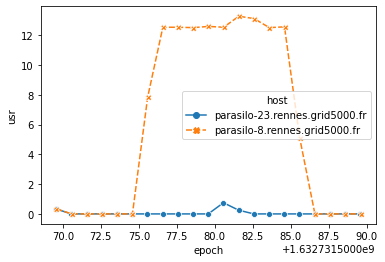

In [7]:
# let's show the metrics !
sns.lineplot(data=result, x="epoch", y="usr", hue="host", markers=True, style="host")

## Packet sniffing with tcpdump

### Capture

In [8]:
# start a capture
# - on all the interface configured on the my_network network
# - we dump icmp traffic only
# - for the duration of the commands (here a client is pigging the server)
with en.TCPDump(
    hosts=roles["xp"], ifnames=["any"], options="icmp"
) as t:
    backup_dir = t.backup_dir
    _ = en.run(f"ping -c10 {roles['control'][0].address}", roles["agent"])


PLAY [all] **********************************************************************************************************************************************************************************

TASK [Stopping tcpdump on any] **************************************************************************************************************************************************************
 [started TASK: Stopping tcpdump on any on parasilo-23.rennes.grid5000.fr]
 [started TASK: Stopping tcpdump on any on parasilo-8.rennes.grid5000.fr]
changed: [parasilo-23.rennes.grid5000.fr]
changed: [parasilo-8.rennes.grid5000.fr]

TASK [debug] ********************************************************************************************************************************************************************************
 [started TASK: debug on parasilo-23.rennes.grid5000.fr]
 [started TASK: debug on parasilo-8.rennes.grid5000.fr]
ok: [parasilo-23.rennes.grid5000.fr] => {
    "tcpdump_ifs": []
}
ok: [parasilo-8.

[WARNING]: Consider using the unarchive module rather than running 'tar'.  If you need to use command because unarchive is insufficient you can add 'warn: false' to this command task or
set 'command_warnings=False' in ansible.cfg to get rid of this message.


changed: [parasilo-23.rennes.grid5000.fr]
changed: [parasilo-8.rennes.grid5000.fr]

TASK [fetch] ********************************************************************************************************************************************************************************
 [started TASK: fetch on parasilo-23.rennes.grid5000.fr]
 [started TASK: fetch on parasilo-8.rennes.grid5000.fr]
changed: [parasilo-8.rennes.grid5000.fr]
changed: [parasilo-23.rennes.grid5000.fr]


### Visualization

In [9]:
from scapy.all import rdpcap
import tarfile
# Examples:
# create a dictionnary of (alias, if) -> list of decoded packets by scapy
decoded_pcaps = dict()
for host in roles["control"]:
    host_dir = backup_dir / host.alias
    t = tarfile.open(host_dir / "tcpdump.tar.gz")
    t.extractall(host_dir / "extracted")
    # get all extracted pcap for this host
    pcaps = (host_dir / "extracted").rglob("*.pcap")
    for pcap in pcaps:
        decoded_pcaps.setdefault((host.alias, pcap.with_suffix("").name),
                                 rdpcap(str(pcap)))

# Displaying some packets
for (host, ifs), packets in decoded_pcaps.items():
    print(host, ifs)
    packets[0].show()
    packets[1].show()

parasilo-23.rennes.grid5000.fr any
###[ cooked linux ]### 
  pkttype   = unicast
  lladdrtype= 0x1
  lladdrlen = 6
  src       = '\\xec\\xf4\\xbb\\xd0\\xf2H'
  proto     = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 84
     id        = 12493
     flags     = DF
     frag      = 0
     ttl       = 64
     proto     = icmp
     chksum    = 0xef9b
     src       = 172.16.97.8
     dst       = 172.16.97.23
     \options   \
###[ ICMP ]### 
        type      = echo-request
        code      = 0
        chksum    = 0x45cb
        id        = 0x2943
        seq       = 0x1
        unused    = ''
###[ Raw ]### 
           load      = '\u0381Qa\x00\x00\x00\x00\\xaa:\x00\x00\x00\x00\x00\x00\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f !"#$%&\'()*+,-./01234567'

###[ cooked linux ]### 
  pkttype   = unicast
  lladdrtype= 0x1
  lladdrlen = 6
  src       = '\\xec\\xf4\\xbb\\xd0\\xf2H'
  proto     = IPv4
###[ IP ]### 
     version

### Capture on a specific network

You can start a capture on a dedicated network by specifying it to TCPDump
This will sniff all the packet that go through an interface configured in this specific network
You need to call `sync_info` first to enable the translation (network logical name)->interface name

In [10]:
roles = en.sync_info(roles, networks)


PLAY [all] **********************************************************************************************************************************************************************************

TASK [hostname] *****************************************************************************************************************************************************************************
 [started TASK: hostname on parasilo-23.rennes.grid5000.fr]
 [started TASK: hostname on parasilo-8.rennes.grid5000.fr]
changed: [parasilo-23.rennes.grid5000.fr]
changed: [parasilo-8.rennes.grid5000.fr]

PLAY [Gather facts for all hosts] ***********************************************************************************************************************************************************

TASK [Gathering Facts] **********************************************************************************************************************************************************************
ok: [parasilo-8.rennes.grid5000.fr

In [11]:
# start a capture
# - on all the interface configured on the my_network network
# - we dump icmp traffic only
# - for the duration of the commands (here a client is pigging the server)
with en.TCPDump(
    hosts=roles["xp"], networks=networks["my_network"], options="icmp"
) as t:
    backup_dir = t.backup_dir
    _ = en.run(f"ping -c10 {roles['control'][0].address}", roles["agent"])


PLAY [all] **********************************************************************************************************************************************************************************

TASK [debug] ********************************************************************************************************************************************************************************
 [started TASK: debug on parasilo-23.rennes.grid5000.fr]
 [started TASK: debug on parasilo-8.rennes.grid5000.fr]
ok: [parasilo-23.rennes.grid5000.fr] => {
    "tcpdump_ifs": [
        "eno1"
    ]
}
ok: [parasilo-8.rennes.grid5000.fr] => {
    "tcpdump_ifs": [
        "eno1"
    ]
}

TASK [Stopping some tcpdumps] ***************************************************************************************************************************************************************
 [started TASK: Stopping some tcpdumps on parasilo-23.rennes.grid5000.fr]
 [started TASK: Stopping some tcpdumps on parasilo-8.rennes.grid5000.

## Monitoring with Telegraf/[InfluxDB|prometheus]/grafana 

In [13]:
monitoring = en.TIGMonitoring(collector=roles["control"][0], agent=roles["agent"], ui=roles["control"][0])
monitoring

In [14]:
monitoring.deploy()


PLAY [Gather facts] *************************************************************************************************************************************************************************

TASK [Gathering Facts] **********************************************************************************************************************************************************************
ok: [parasilo-23.rennes.grid5000.fr]
ok: [parasilo-8.rennes.grid5000.fr]

TASK [Gather facts on all hosts] ************************************************************************************************************************************************************
ok: [parasilo-23.rennes.grid5000.fr]
ok: [parasilo-8.rennes.grid5000.fr]

PLAY [Monitoring - Telegraf agents] *********************************************************************************************************************************************************

TASK [Gathering Facts] ******************************************************************

[WARNING]: Could not match supplied host pattern, ignoring: prometheus



PLAY [Monitoring - Prometheus collector] ****************************************************************************************************************************************************
skipping: no hosts matched

PLAY [Monitoring - Grafana UI] **************************************************************************************************************************************************************

TASK [Gathering Facts] **********************************************************************************************************************************************************************
ok: [parasilo-23.rennes.grid5000.fr]

TASK [python3 : Install python3] ************************************************************************************************************************************************************
changed: [parasilo-23.rennes.grid5000.fr]

TASK [docker : Install docker] **************************************************************************************************

In [15]:
en.run_command("stress --cpu 4 --timeout 60", roles=roles["agent"], background=True)


PLAY [all] **********************************************************************************************************************************************************************************

TASK [stress --cpu 4 --timeout 60] **********************************************************************************************************************************************************
 [started TASK: stress --cpu 4 --timeout 60 on parasilo-8.rennes.grid5000.fr]
changed: [parasilo-8.rennes.grid5000.fr]


AsyncCommandResult(host='parasilo-8.rennes.grid5000.fr', task='stress --cpu 4 --timeout 60', status='OK', payload={'started': 1, 'finished': 0, 'ansible_job_id': '10624236931.18278', 'results_file': '/root/.ansible_async/10624236931.18278', 'changed': True, '_ansible_no_log': False})

In [16]:
# create a tunnel to the service running inside g5k
tunnel = en.G5kTunnel(address=monitoring.ui.address, port=3000)
local_address, local_port, _ = tunnel.start()
print(f"The service is running at http://localhost:{local_port} (admin:admin)")

2021-09-27 10:36:20,060| ERROR   | Password is required for key /home/msimonin/.ssh/id_rsa
ERROR:sshtunnel.SSHTunnelForwarder:Password is required for key /home/msimonin/.ssh/id_rsa
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


The service is running at http://localhost:33201 (admin:admin)


In [17]:
# don't forget to close it
tunnel.close()

To not forget to close the tunnel you can use a context manager: the tunnel will be closed automatically when exiting the context manager.

In [18]:
import time
with en.G5kTunnel(address=monitoring.ui.address, port=3000) as (_, local_port, _):
    print(f"The service is running at http://localhost:{local_port}")
    time.sleep(60)
    

2021-09-27 10:36:20,519| ERROR   | Password is required for key /home/msimonin/.ssh/id_rsa
ERROR:sshtunnel.SSHTunnelForwarder:Password is required for key /home/msimonin/.ssh/id_rsa
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


The service is running at http://localhost:38351


## Cleaning

In [19]:
provider.destroy()

INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from grenoble
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from lille
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from luxembourg
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from lyon
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from nancy
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from nantes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading 1820192 from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_observability from sophia
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Killing the job (rennes, 1820192)
